In [1]:

import math
import numpy as np
import folium
from geopy.distance import distance
from math import radians, sin, cos, sqrt, tan, atan, degrees

# Calculating the FOV of the Main Camera on Samsung Note 20 Ultra and Boundary Angles


## 1. Technical Data of the Main Camera
- **Focal length:** 26 mm (equivalent **35mm film format**, also known as **full-frame format** in digital photography.).
- To calculate the Field of View (FOV) for the Samsung Note 20 Ultra using the full-frame format equivalent, we will treat its reported focal lengths (**26mm for main wide**, 13mm for ultra-wide, and 120mm for telephoto) as "35mm equivalent focal lengths." This means we will use the standard **full-frame dimensions** of **36mm × 24mm** as the sensor size.

## 2. FOV Calculation Formula
$$
\text{FOV} = 2 \cdot \arctan\left(\frac{\text{sensor size}}{2 \cdot \text{focal length}}\right)
$$

### Horizontal FOV (hFOV):
$$
\text{hFOV} = 2 \cdot \arctan\left(\frac{\text{Sensor width}}{2 \cdot \text{focal length}}\right)
$$

### Vertical FOV (vFOV):
$$
\text{vFOV} = 2 \cdot \arctan\left(\frac{\text{sensor height}}{2 \cdot \text{focal length}}\right)
$$

### Diagonal FOV (dFOV):
$$
\text{dFOV} = 2 \cdot \arctan\left(\frac{\text{sensor diagonal}}{2 \cdot \text{focal length}}\right)
$$

In [2]:
def calculate_fov(sensor_size, focal_length):
    """
    Calculate the Field of View (FOV).

    :param sensor_size: Size of the sensor (in mm).
    :param focal_length: Focal length of the lens (in mm).
    :return: FOV in degrees.
    """
    fov = 2 * degrees(atan(sensor_size / (2 * focal_length)))
    return fov

In [3]:
# Sensor dimensions and focal length in mm
sensor_diagonal = sqrt(36**2 + 24**2)
sensor_ratio = (4, 3)   # Aspect ratio of the sensor
sensor_height = sensor_diagonal * (sensor_ratio[0] / sqrt(sensor_ratio[0]**2 + sensor_ratio[1]**2))
sensor_width = sensor_diagonal * (sensor_ratio[1] / sqrt(sensor_ratio[0]**2 + sensor_ratio[1]**2))
focal_length = 26

# Calculate FOVs
hfov = calculate_fov(sensor_width, focal_length)   # Horizontal FOV
vfov = calculate_fov(sensor_height, focal_length)  # Vertical FOV
dfov = calculate_fov(sensor_diagonal, focal_length)  # Diagonal FOV

# Print results
print("Horizontal FOV:", round(hfov, 2), "degrees")
print("Vertical FOV:", round(vfov, 2), "degrees")
print("Diagonal FOV:", round(dfov, 2), "degrees")

Horizontal FOV: 53.06 degrees
Vertical FOV: 67.3 degrees
Diagonal FOV: 79.52 degrees


If the camera uses a **1:1 aspect ratio**, it will indeed crop the image to create a square format. In this case:

- The **horizontal FOV (hFOV)** and **vertical FOV (vFOV)** will become equal because the sensor width and height are constrained to the same value (cropping the larger dimension to match the smaller one).

- Using the previously calculated **53.06° vFOV** for the main wide camera, we find that the **hFOV** and **vFOV** will both equal **53.06°**.

- The diagonal field of view (dFOV) can be calculated using the relationship between the horizontal, vertical, and diagonal dimensions of the cropped sensor:

$$
\text{dFOV} = 2 \times \arctan\left(\frac{\sqrt{(\text{Sensor Width})^2 + (\text{Sensor Height})^2}}{2 \times \text{Focal Length}}\right)
$$

$$
\text{dFOV} = 2 \times \arctan\left(\sqrt{2} \times \tan\left(\frac{\text{hFOV}}{2}\right)\right)
$$

In [4]:
hfov_1_1 = hfov
vfov_1_1 = hfov
dfov_1_1 = 2 * degrees(atan(sqrt(2) * tan(radians(hfov / 2))))

# Print results
print("Horizontal FOV in a 1:1 aspect ratio:", round(hfov_1_1, 2), "degrees")
print("Vertical FOV in a 1:1 aspect ratio:", round(vfov, 2), "degrees")
print("Diagonal FOV in a 1:1 aspect ratio:", round(dfov_1_1, 2), "degrees")

Horizontal FOV in a 1:1 aspect ratio: 53.06 degrees
Vertical FOV in a 1:1 aspect ratio: 67.3 degrees
Diagonal FOV in a 1:1 aspect ratio: 70.45 degrees


In [5]:
vfov_16_9 = vfov
sensor_width_16_9 = sensor_width * 9/12
hfov_16_9 = calculate_fov(sensor_width_16_9, focal_length)
#dfov_16_9 = 2 * degrees(atan(sqrt(2) * tan(radians(hfov / 2))))

# Print results
print("Horizontal FOV in a 16:9 aspect ratio:", round(hfov_16_9, 2), "degrees")
print("Vertical FOV in a 16:9 aspect ratio:", round(vfov_16_9, 2), "degrees")
#print("Diagonal FOV in a 16:9 aspect ratio:", round(dfov_16_9, 2), "degrees")

Horizontal FOV in a 16:9 aspect ratio: 41.05 degrees
Vertical FOV in a 16:9 aspect ratio: 67.3 degrees


### **Quy trình sử dụng Compass và chụp ảnh bầu trời**
1. **Xác định hướng (trước khi dựng điện thoại lên)**:
   - Đặt điện thoại **song song với mặt đất**.
   - Dùng Compass để ghi lại hướng trung tâm (θc), ví dụ: 45° (Đông Bắc).
   - Điều này giúp đảm bảo thông tin đầu vào chính xác cho việc tính toán góc biên trái và phải.

2. **Dựng điện thoại để chụp ảnh**:
   - Sau khi biết hướng trung tâm, bạn có thể dựng điện thoại theo góc phù hợp để chụp bầu trời.
   - Cách đặt:
     - **Thẳng đứng (90°)** nếu muốn tập trung hoàn toàn vào bầu trời.
     - **Nghiêng nhẹ** nếu muốn bao quát cả đường chân trời.

3. **Tính toán vùng quan sát**:
   - Dựa trên hướng trung tâm đo được và góc mở của camera (FOV), tính toán góc biên để xác định vùng bầu trời trong ảnh.

---

### **Lý do không dùng Compass khi điện thoại dựng đứng**
- Khi điện thoại dựng đứng, cảm biến từ trường đo hướng **theo phương dọc** không đáng tin cậy do nhiễu từ trường theo phương khác.
- Kết quả có thể sai lệch, ảnh hưởng đến độ chính xác khi tính toán góc biên.

---

**Tóm lại**: Đặt điện thoại **song song với mặt đất để đo hướng**, sau đó dựng lên để chụp ảnh. Điều này giúp đảm bảo cả dữ liệu đầu vào và bức ảnh đều chính xác.


## Calculating Left and Right Boundary Angles (Horizontal)
- **Central orientation (θc):** mesured by Compass.
- **Left boundary angle (θ_left):**
$$
\theta_{\text{left}} = \theta_c - \frac{\text{hFOV}}{2}
$$
- **Right boundary angle (θ_right):**
$$
\theta_{\text{right}} = \theta_c + \frac{\text{hFOV}}{2}
$$

In [6]:
def calculate_boundary_angles(center_angle, fov):
    """
    Calculate the left and right boundary angles based on the center angle and FOV.

    :param center_angle: Center orientation angle (in degrees).
    :param fov: Field of View (in degrees).
    :return: Left and right angles.
    """
    left_angle = center_angle - (fov / 2)
    right_angle = center_angle + (fov / 2)
    return left_angle, right_angle

<img src="flight map.png" alt="Flight Map" width="600"/>

In [7]:
# Center orientation angle (e.g., facing 45 degrees)
center_orientation = (302 + 265) / 2  # in degrees
print("Center orientation:", center_orientation, "degrees")

# Calculate left and right boundary angles
left_angle, right_angle = calculate_boundary_angles(center_orientation, hfov_16_9)

print("Left boundary angle:", round(left_angle, 2), "degrees")
print("Right boundary angle:", round(right_angle, 2), "degrees")

Center orientation: 283.5 degrees
Left boundary angle: 262.97 degrees
Right boundary angle: 304.03 degrees


#### **Thay đổi vĩ độ $( \Delta \text{lat} $):**
$$
\Delta \text{lat} = \frac{D}{R} \cdot \cos(\theta)
$$

#### **Thay đổi kinh độ ($ \Delta \text{lon} $):**
$$
\Delta \text{lon} = \frac{D}{R \cdot \cos(\text{latitude})} \cdot \sin(\theta)
$$

- $ D $: Khoảng cách quan sát tối đa (tính bằng mét).
- $ R $: Bán kính Trái Đất (6,371 km = 6,371,000 m).
- $ \theta $: Góc (hướng biên trái hoặc phải, tính bằng radian).
- $ \text{latitude} $: Vĩ độ hiện tại của camera.

In [8]:
def calculate_gps_coordinates(lat0, lon0, distance, angle, earth_radius=6_371_000):
    """
    Calculate GPS coordinates based on distance and angle.
    
    :param lat0: Initial latitude in degrees.
    :param lon0: Initial longitude in degrees.
    :param distance: Distance in meters.
    :param angle: Angle in degrees.
    :param earth_radius: Radius of the Earth in meters (default is 6,371,000 m).
    :return: New latitude and longitude in degrees.
    """
    angle_rad = radians(angle)
    lat0_rad = radians(lat0)
    lon0_rad = radians(lon0)
    
    delta_lat = (distance / earth_radius) * cos(angle_rad)
    new_lat = lat0_rad + delta_lat
    
    delta_lon = (distance / (earth_radius * cos(lat0_rad))) * sin(angle_rad)
    new_lon = lon0_rad + delta_lon
    
    return degrees(new_lat), degrees(new_lon)

In [9]:
# Function to calculate GPS coordinates based on distance and angle
def calculate_coordinates(lat, lon, dist, angle):
    """
    Calculate new GPS coordinates based on distance and angle.
    :param lat: Latitude of the starting point.
    :param lon: Longitude of the starting point.
    :param dist: Distance in meters.
    :param angle: Angle in degrees (bearing).
    :return: Tuple of new latitude and longitude.
    """
    point = distance(meters=dist).destination((lat, lon), bearing=angle)
    return point.latitude, point.longitude

Công thức $ D = \sqrt{2 \cdot R \cdot h} $ xuất phát từ hình học cầu, được dùng để tính khoảng cách từ một vị trí quan sát trên bề mặt Trái Đất đến đường chân trời.

1. **Mô hình hình học**:
   - Trái Đất được coi là một hình cầu với bán kính $ R $.
   - Một điểm quan sát ở độ cao $ h $ nằm ngoài bề mặt Trái Đất.
   - Đường chân trời được xác định là giao điểm của đường thẳng đi qua mắt quan sát và bề mặt Trái Đất.

2. **Phương trình hình học**:
   - Từ định lý Pythagoras, với tam giác vuông tạo bởi:
     - $ R $: Bán kính Trái Đất.
     - $ R + h $: Khoảng cách từ tâm Trái Đất đến điểm quan sát.
     - $ D $: Khoảng cách từ điểm quan sát đến đường chân trời.
   - Quan hệ: $(R + h)^2 = R^2 + D^2$.

3. **Đơn giản hóa**:
   - Vì $ h \ll R $ (độ cao nhỏ hơn rất nhiều so với bán kính Trái Đất), có thể xấp xỉ:
     $$
     R + h \approx R
     $$
   - Suy ra:
     $$
     D^2 \approx 2 \cdot R \cdot h
     $$
   - Do đó:
     $$
     D = \sqrt{2 \cdot R \cdot h}
     $$

In [10]:
# Get current GPS coordinates
#g = geocoder.ip('me')  # Get location based on IP address
#lat1, lon1 = g.latlng
lat1, lon1 = 43.57072605547293, 1.4682620342267738

# Increase distance for observation from a high floor
observation_distance = sqrt(2 * 6_371_000 * 16)  # meters
print("Observable distance:", observation_distance)

# Calculate GPS coordinates for left and right boundaries
left_coordinates = calculate_gps_coordinates(lat1, lon1, observation_distance, left_angle)
right_coordinates = calculate_gps_coordinates(lat1, lon1, observation_distance, right_angle)

# Print results
print("Current GPS coordinates:", (lat1, lon1))
print("Left boundary GPS coordinates:", left_coordinates)
print("Right boundary GPS coordinates:", right_coordinates)

Observable distance: 14278.37525771052
Current GPS coordinates: (43.57072605547293, 1.4682620342267738)
Left boundary GPS coordinates: (43.55501685264567, 1.2923617776115537)
Right boundary GPS coordinates: (43.642581412586914, 1.3213772245005408)


In [11]:
# Calculate boundary coordinates
boundary_points = []
for angle in range(int(left_angle), int(right_angle) + 1):
    boundary_points.append(calculate_gps_coordinates(lat1, lon1, observation_distance, angle))

# Add starting and ending points to close the polygon
boundary_points.insert(0, (lat1, lon1))
boundary_points.append((lat1, lon1))

# Create a folium map
m = folium.Map(location=[lat1, lon1], zoom_start=14)

# Add the contour area to the map
folium.Polygon(
    locations=boundary_points,
    color="blue",
    weight=2,
    fill=True,
    fill_color="blue",
    fill_opacity=0.4,
).add_to(m)

# Add a marker for the starting point
folium.Marker(
    [lat1, lon1],
    popup="Observation Point",
    icon=folium.Icon(color="red", icon="info-sign")
).add_to(m)

m

In [12]:
# Initial camera 1 coordinates and parameters
h = 12000  # Altitude in meters

# Calculate optimal distance
optimal_distance = 2 * (h / tan(radians(60)))
print(f"Optimal distance between cameras: {optimal_distance:.2f} m")

Optimal distance between cameras: 13856.41 m


In [13]:
center_orientation1 = center_orientation

# Calculate new camera 2 position
lat2, lon2 = calculate_gps_coordinates(lat1, lon1, optimal_distance, center_orientation1)

# Calculate new camera 2 orientation
center_orientation2 = (center_orientation1 + 180) % 360

# Print results
print("Camera 2 GPS Coordinates:", (lat2, lon2))
print("Camera 2 Orientation:", round(center_orientation2, 2), "degrees")

Camera 2 GPS Coordinates: (43.59981653599691, 1.301020434065065)
Camera 2 Orientation: 103.5 degrees


In [14]:
# Calculate Camera 2 boundary
left_angle2, right_angle2 = calculate_boundary_angles(center_orientation2, hfov)
boundary_points2 = [calculate_gps_coordinates(lat2, lon2, observation_distance, angle) for angle in range(int(left_angle2), int(right_angle2) + 1)]
boundary_points2.insert(0, (lat2, lon2))
boundary_points2.append((lat2, lon2))

# Create folium map
m = folium.Map(location=[lat1, lon1], zoom_start=12)

# Add Camera 1 observation area
folium.Polygon(
    locations=boundary_points,
    color="blue",
    weight=2,
    fill=True,
    fill_color="blue",fill_opacity=0.4,
    popup="Camera 1 Area"
).add_to(m)

# Add Camera 2 observation area
folium.Polygon(
    locations=boundary_points2,
    color="green",
    weight=2,
    fill=True,
    fill_color="green",
    fill_opacity=0.4,
    popup="Camera 2 Area"
).add_to(m)

# Add markers for camera locations
folium.Marker([lat1, lon1], popup="Camera 1", icon=folium.Icon(color="red")).add_to(m)
folium.Marker([lat2, lon2], popup="Camera 2", icon=folium.Icon(color="blue")).add_to(m)

# Save and display map
m

In [42]:
def calculate_distance(lat1, lon1, alt1, lat2, lon2, alt2):
    R = 6371000  # Bán kính Trái Đất tính bằng mét

    # Chuyển đổi độ sang radian
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    # Haversine formula
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = math.sin(dlat/2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))

    # Khoảng cách trên mặt đất
    ground_distance = R * c

    # Tính khoảng cách trong không gian 3D
    height_diff = alt2 - alt1
    distance = math.sqrt(ground_distance**2 + height_diff**2)
    return distance

def calculate_angles(pixel, resolution, hfov, vfov, tilt_angle):
    hfov_rad = math.radians(hfov)
    vfov_rad = math.radians(vfov)
    tilt_angle_rad = math.radians(tilt_angle)

    # Calculate alpha angle (horizontal)
    alpha = -math.atan((pixel[0] - resolution[0]/2) / (resolution[0]/2) * math.tan(hfov_rad/2))

    # Calculate beta angle (vertical)
    beta = tilt_angle_rad + math.atan((pixel[1] - resolution[1]/2) / (resolution[1]/2) * math.tan(vfov_rad/2))

    return alpha, beta

def calculate_direction_vector(alpha, beta, is_camera2=False):
    if not is_camera2:
        costhetax = math.sqrt(1 - math.sin(alpha)**2 - math.sin(beta)**2)
        costhetay = math.sin(alpha)
        costhetaz = math.sin(beta)
    else:
        costhetax = -math.sqrt(1 - math.sin(alpha)**2 - math.sin(beta)**2)
        costhetay = -math.sin(alpha)
        costhetaz = math.sin(beta)
    
    return np.array([costhetax, costhetay, costhetaz])

def find_closest_point(P1, P2, M1, M2):
    v = P2 - P1
    t = np.dot(np.cross(v, M2), np.cross(M1, M2)) / np.linalg.norm(np.cross(M1, M2))**2
    s = np.dot(np.cross(v, M1), np.cross(M1, M2)) / np.linalg.norm(np.cross(M1, M2))**2
    
    Pc1 = P1 + t * M1
    Pc2 = P2 + s * M2
    
    return (Pc1 + Pc2) / 2

def calculate_aircraft_position(lat1, lon1, alt1, lat2, lon2, alt2, pixel1, pixel2, resolution1, resolution2, hfov1, vfov1, hfov2, vfov2, tilt_angle1, tilt_angle2):
    # Tính khoảng cách giữa hai camera
    D = calculate_distance(lat1, lon1, alt1, lat2, lon2, alt2)

    # Thiết lập vị trí camera cho tính toán, bao gồm cả độ cao
    camera1_pos = np.array([0, 0, alt1])
    camera2_pos = np.array([D, 0, alt2])

    # Tính các góc alpha và beta cho cả hai camera
    alpha1, beta1 = calculate_angles(pixel1, resolution1, hfov1, vfov1, tilt_angle1)
    alpha2, beta2 = calculate_angles(pixel2, resolution2, hfov2, vfov2, tilt_angle2)

    # Tính vector hướng cho cả hai camera
    M1 = calculate_direction_vector(alpha1, beta1)
    M2 = calculate_direction_vector(alpha2, beta2, is_camera2=True)

    # Tìm điểm gần nhất (vị trí máy bay)
    aircraft_position = find_closest_point(camera1_pos, camera2_pos, M1, M2)

    # Chiều cao của máy bay chính là tọa độ z của aircraft_position
    aircraft_height = aircraft_position[2]

    # Tính khoảng cách từ điểm ảnh đến từng camera
    distance_to_camera1 = np.linalg.norm(aircraft_position - camera1_pos)
    distance_to_camera2 = np.linalg.norm(aircraft_position - camera2_pos)

    return D, aircraft_height, aircraft_position, M1, M2, alpha1, alpha2, beta1, beta2, distance_to_camera1, distance_to_camera2, camera1_pos, camera2_pos

In [64]:
# Sử dụng hàm
lat1, lon1, alt1 = 43.57072605547293, 1.4682620342267738, 100  # Tọa độ và độ cao camera 1
lat2, lon2, alt2 = 43.59981653599691, 1.301020434065065, 100  # Tọa độ và độ cao camera 2
pixel1 = (1520, 2160)
pixel2 = (3840, 4320)
resolution1 = (3840, 2160)
resolution2 = (7680, 4320)
hfov1, vfov1 = 53.06, 67.3
hfov2, vfov2 = 53.06, 67.3
tilt_angle1 = 25
tilt_angle2 = 25

D, aircraft_height, aircraft_position, M1, M2, alpha1, alpha2, beta1, beta2, distance_to_camera1, distance_to_camera2, camera1_pos, camera2_pos = calculate_aircraft_position(
    lat1, lon1, alt1, lat2, lon2, alt2, pixel1, pixel2, resolution1, resolution2, hfov1, vfov1, hfov2, vfov2, tilt_angle1, tilt_angle2)

print(f"Khoảng cách giữa hai camera: {D:.2f} meters")
print(f"Chiều cao của máy bay: {aircraft_height:.2f} meters")
print(f"Góc giữa đường thẳng nối cam 1 và điểm ảnh với XOZ (Alpha1): {math.degrees(alpha1):.2f} degrees")
print(f"Vị trí máy bay (tuyệt đối): ({aircraft_position[0]:.2f}, {aircraft_position[1]:.2f}, {aircraft_position[2]:.2f}) meters")
print(f"Khoảng cách từ điểm ảnh đến camera 1: {distance_to_camera1:.2f} meters")
print(f"Khoảng cách từ điểm ảnh đến camera 2: {distance_to_camera2:.2f} meters")
print(f"Alpha2 (degrees): {math.degrees(alpha2):.2f}")
print(f"Beta1 (degrees): {math.degrees(beta1):.2f}")
print(f"Beta2 (degrees): {math.degrees(beta2):.2f}")
print(f"Direction vector M1: ({M1[0]:.4f}, {M1[1]:.4f}, {M1[2]:.4f})")
print(f"Direction vector M2: ({M2[0]:.4f}, {M2[1]:.4f}, {M2[2]:.4f})")
print(f"Camera 1 position: ({camera1_pos[0]:.2f}, {camera1_pos[1]:.2f}, {camera1_pos[2]:.2f}) meters")
print(f"Camera 2 position: ({camera2_pos[0]:.2f}, {camera2_pos[1]:.2f}, {camera2_pos[2]:.2f}) meters")

Khoảng cách giữa hai camera: 13853.24 meters
Chiều cao của máy bay: 11469.92 meters
Góc giữa đường thẳng nối cam 1 và điểm ảnh với XOZ (Alpha1): 5.94 degrees
Vị trí máy bay (tuyệt đối): (6832.15, 686.10, 11469.92) meters
Khoảng cách từ điểm ảnh đến camera 1: 13282.48 meters
Khoảng cách từ điểm ảnh đến camera 2: 13380.64 meters
Alpha2 (degrees): -0.00
Beta1 (degrees): 58.65
Beta2 (degrees): 58.65
Direction vector M1: (0.5099, 0.1034, 0.8540)
Direction vector M2: (-0.5203, 0.0000, 0.8540)
Camera 1 position: (0.00, 0.00, 100.00) meters
Camera 2 position: (13853.24, 0.00, 100.00) meters


In [65]:
# Tính toán hình chiếu khoảng cách giữa camera 1 và máy bay dưới mặt đất
projected_distance = sqrt(aircraft_position[0]**2 + aircraft_position[1]**2)

# Calculate aircraft position
lat_aircraft, lon_aircraft = calculate_gps_coordinates(lat1, lon1, projected_distance, (center_orientation1 - degrees(alpha1)) % 360)
alt_aircraft = aircraft_height

# Print results
print("Aircraft GPS Coordinates:", (lat_aircraft, lon_aircraft, alt_aircraft))

Aircraft GPS Coordinates: (43.5788527337165, 1.3837721625306167, 11469.924326768829)


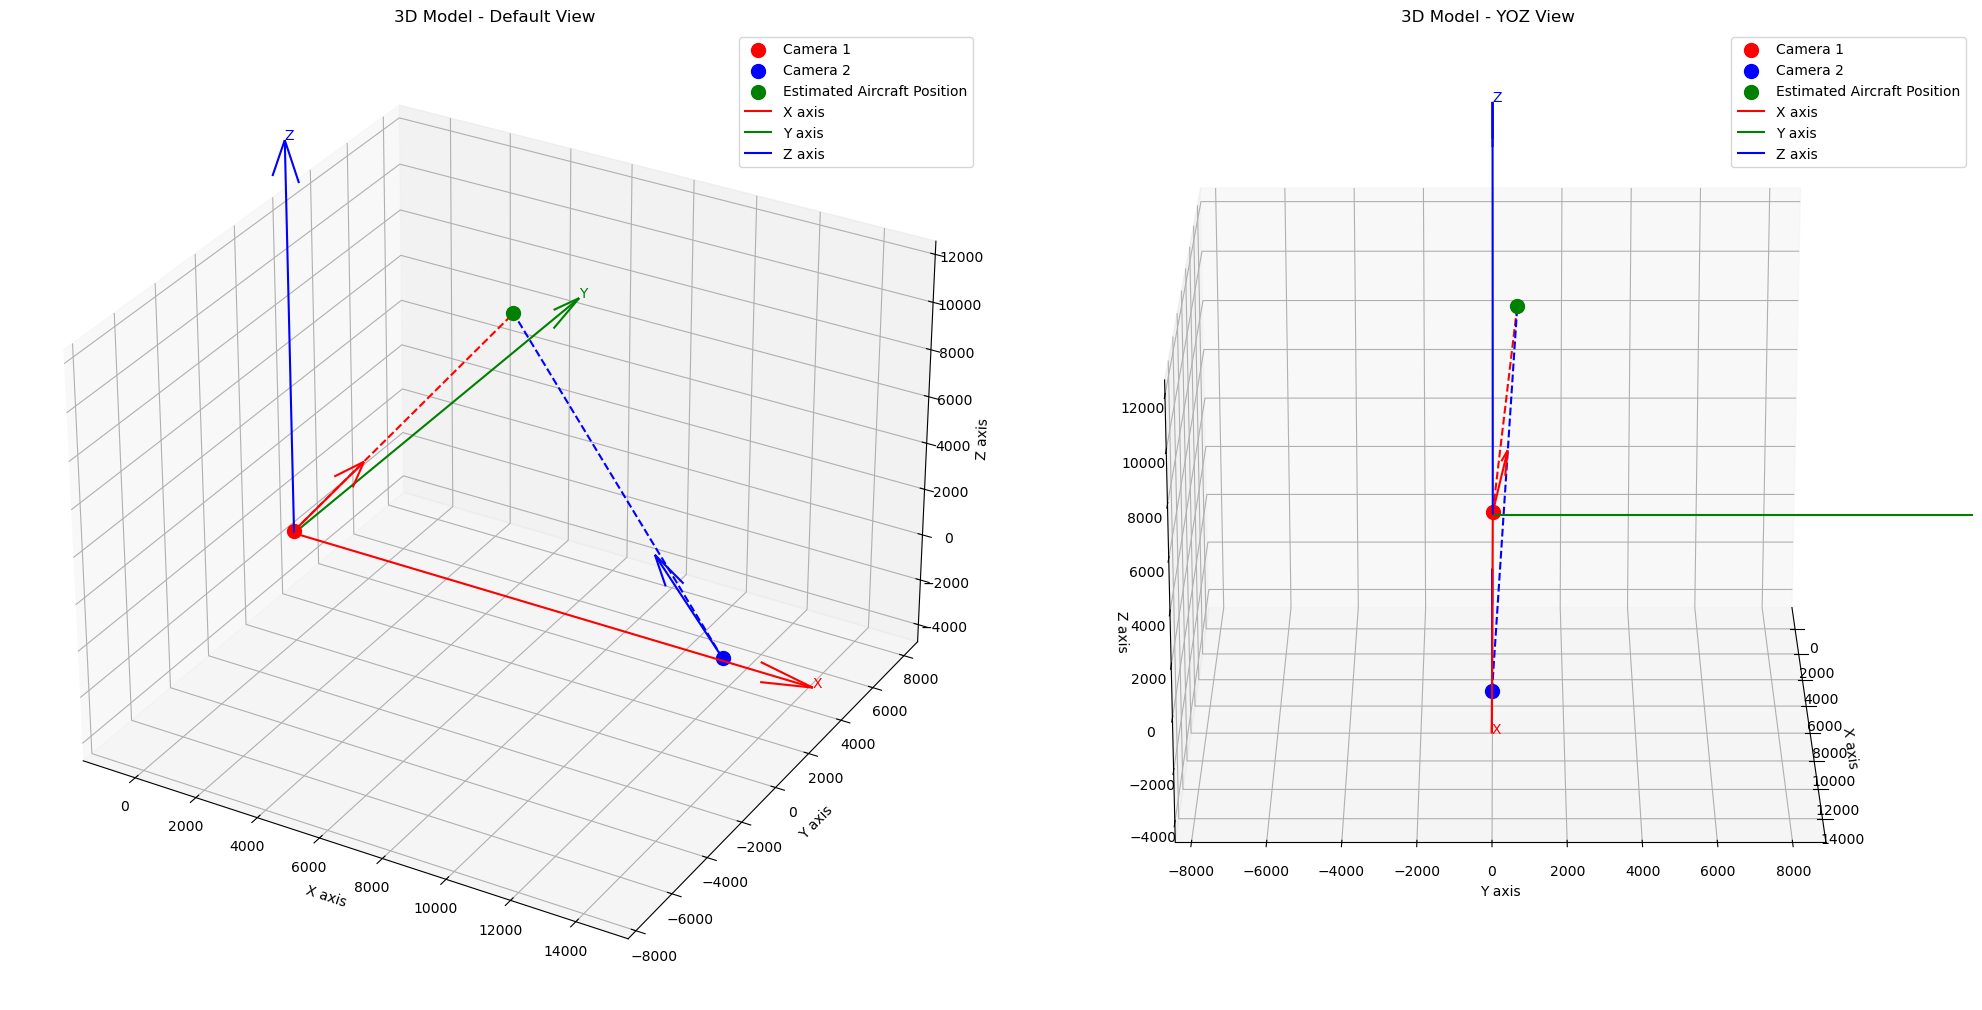

In [66]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_model(D, aircraft_position, M1, M2, camera1_pos, camera2_pos):
    fig = plt.figure(figsize=(20, 10))
    
    # Subplot 1: Default view
    ax1 = fig.add_subplot(121, projection='3d')
    plot_subplot(ax1, D, aircraft_position, M1, M2, camera1_pos, camera2_pos, "Default View")
    
    # Subplot 2: YOZ view
    ax2 = fig.add_subplot(122, projection='3d')
    plot_subplot(ax2, D, aircraft_position, M1, M2, camera1_pos, camera2_pos, "YOZ View")
    ax2.view_init(elev=20, azim=0)
    
    plt.tight_layout()
    plt.show()

def plot_subplot(ax, D, aircraft_position, M1, M2, camera1_pos, camera2_pos, view_title):
    # Set scale factor based on camera distance
    scale = D * 0.3  # You can adjust this multiplier to change the relative length

    # Plot cameras
    ax.scatter(*camera1_pos, color='r', s=100, label='Camera 1')
    ax.scatter(*camera2_pos, color='b', s=100, label='Camera 2')

    # Plot camera direction vectors
    ax.quiver(*camera1_pos, *(M1 * scale), color='r')
    ax.quiver(*camera2_pos, *(M2 * scale), color='b')

    # Plot estimated aircraft position
    ax.scatter(*aircraft_position, color='g', s=100, label='Estimated Aircraft Position')

    # Connect cameras to aircraft position
    ax.plot([camera1_pos[0], aircraft_position[0]], 
            [camera1_pos[1], aircraft_position[1]], 
            [camera1_pos[2], aircraft_position[2]], 'r--')
    ax.plot([camera2_pos[0], aircraft_position[0]], 
            [camera2_pos[1], aircraft_position[1]], 
            [camera2_pos[2], aircraft_position[2]], 'b--')

    # Add coordinate axes
    origin = [0, 0, 0]
    axis_length = max(np.max(np.abs(aircraft_position)), D, 
                      np.max(np.abs(camera1_pos)), np.max(np.abs(camera2_pos))) * 1.2
    ax.quiver(*origin, axis_length, 0, 0, color='r', arrow_length_ratio=0.1, label='X axis')
    ax.quiver(*origin, 0, axis_length, 0, color='g', arrow_length_ratio=0.1, label='Y axis')
    ax.quiver(*origin, 0, 0, axis_length, color='b', arrow_length_ratio=0.1, label='Z axis')

    # Set labels and title
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title(f'3D Model - {view_title}')

    # Set axis limits
    max_range = np.array([camera1_pos, camera2_pos, aircraft_position, 
                          [axis_length, axis_length, axis_length]]).ptp(axis=0).max() / 2.0
    mid_x = (camera1_pos[0] + camera2_pos[0]) / 2
    mid_y = (camera1_pos[1] + camera2_pos[1] + aircraft_position[1]) / 3
    mid_z = (camera1_pos[2] + camera2_pos[2] + aircraft_position[2]) / 3
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    # Add text labels for axes
    ax.text(axis_length, 0, 0, "X", color='red')
    ax.text(0, axis_length, 0, "Y", color='green')
    ax.text(0, 0, axis_length, "Z", color='blue')

    ax.legend()

# Sử dụng hàm với dữ liệu từ tính toán trước đó
plot_3d_model(D, aircraft_position, M1, M2, camera1_pos, camera2_pos)